In [1]:
import pysindy as ps

import deepSI
from deepSI import System_data
from deepSI.fit_systems import SS_encoder_general
from deepSI.fit_systems.encoders import default_encoder_net, default_state_net, default_output_net
from deepSI.fit_systems.fit_system import My_Simple_DataLoader, print_array_byte_size, Tictoctimer
import torch
from torch import nn

import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from scipy.io import loadmat
import scipy.linalg as lin
import os

from utils import load_data
from SINDy_model import SINDy_model


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import time
from copy import deepcopy
import itertools

c:\Users\Joost\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def NRMS(x_true, x_pred):
    rms = np.sqrt(np.mean((x_true-x_pred)**2, axis=0))
    return rms/np.std(x_true, axis=0)

In [3]:
data_set_name="sc_wnl_noisy"
x_data, u_data, y_data, eq, T, U, set_idx = load_data(set=data_set_name)
[N_arrow, N_train, N_val, N_test] = set_idx[0]

if T is None:
    T = np.eye(x_data.shape[-1])
if U is None:
    U = np.eye(u_data.shape[-1])

# data organizing
x_arrow, u_arrow = x_data[:N_arrow], u_data[:N_arrow,0]
x_train, u_train = x_data[N_arrow:N_arrow+N_train-N_val,:], u_data[N_arrow:N_arrow+N_train-N_val,0]
x_val, u_val     = x_data[N_arrow+N_train-N_val:-N_test,:], u_data[N_arrow+N_train-N_val:-N_test,0]
x_test, u_test   = x_data[-N_test:,:], u_data[-N_test:]

# system data
arrow   = System_data(u=u_arrow, y=x_arrow)
train   = System_data(u=u_train, y=x_train)
val     = System_data(u=u_val[:1000], y=x_val[:1000,:])
test    = System_data(u=u_test, y=x_test)

Data loaded from sc_wnl_noisy!


In [4]:
# feature_library=ps.PolynomialLibrary(degree=10,include_interaction=False)

functions = [lambda x: x,
            #  lambda x: x**2,
            #  lambda x: x**3,
            #  lambda x: x**4,
            #  lambda x: x**5,
             lambda x: np.sin((1/T[0,0])*x),
             lambda x: np.cos((1/T[0,0])*x),
             lambda x: np.sin((2/T[0,0])*x),
             lambda x: np.cos((2/T[0,0])*x),
             lambda x: np.sin((3/T[0,0])*x),
             lambda x: np.cos((3/T[0,0])*x),
             lambda x: np.sin((4/T[0,0])*x),
             lambda x: np.cos((4/T[0,0])*x),
             lambda x: np.sin((5/T[0,0])*x),
             lambda x: np.cos((5/T[0,0])*x),
             lambda x: np.sin((6/T[0,0])*x),
             lambda x: np.cos((6/T[0,0])*x),
             lambda x: np.sin((7/T[0,0])*x),
             lambda x: np.cos((7/T[0,0])*x),
             lambda x: np.sin((8/T[0,0])*x),
             lambda x: np.cos((8/T[0,0])*x),
             lambda x: np.sin((9/T[0,0])*x),
             lambda x: np.cos((9/T[0,0])*x),
             lambda x: np.sin((10/T[0,0])*x),
             lambda x: np.cos((10/T[0,0])*x),
            ]
function_names =    [lambda x: f"{x}",
                    #  lambda x: f"{x}^2",
                    #  lambda x: f"{x}^3",
                    #  lambda x: f"{x}^4",
                    #  lambda x: f"{x}^5",
                     lambda x: f"sin(T{x})",
                     lambda x: f"cos(T{x})",
                     lambda x: f"sin(2T{x})",
                     lambda x: f"cos(2T{x})",
                     lambda x: f"sin(3T{x})",
                     lambda x: f"cos(3T{x})",
                     lambda x: f"sin(4T{x})",
                     lambda x: f"cos(4T{x})",
                     lambda x: f"sin(5T{x})",
                     lambda x: f"cos(5T{x})",
                     lambda x: f"sin(6T{x})",
                     lambda x: f"cos(6T{x})",
                     lambda x: f"sin(7T{x})",
                     lambda x: f"cos(7T{x})",
                     lambda x: f"sin(8T{x})",
                     lambda x: f"cos(8T{x})",
                     lambda x: f"sin(9T{x})",
                     lambda x: f"cos(9T{x})",
                     lambda x: f"sin(10T{x})",
                     lambda x: f"cos(10T{x})",
                    ]
feature_library = ps.CustomLibrary(library_functions=functions, function_names=function_names)

In [5]:
# custom class with basic SINDy implementation
dt = 0.5

optimizer=ps.STLSQ(alpha=5, threshold=0.001)

model = SINDy_model(
  optimizer=optimizer,
  x_data=train.y,
  u_data=train.u,
  x_test=val.y, # if not specified will use data_split to create test set
  u_test=val.u,
  data_split=None, # percentage of x_data/u_data that will be used for testing
  discrete_time=True,
  t_default=dt,
  feature_library=feature_library
)

model.fit_s()
# predicted = model.predict_s()
model.print(precision=6)

(x0)[k+1] = 0.985617 x0[k] + 0.729878 x1[k] + 0.000457 sin(Tx0[k])
(x1)[k+1] = -0.658292 x0[k] + 0.248652 x1[k] + 0.583492 u0[k] + 0.055166 sin(Tx0[k]) + 0.010458 cos(Tx0[k]) + 0.004233 cos(Tx1[k]) + 0.001596 cos(Tu0[k]) + 0.002831 cos(2Tx0[k]) + -0.001442 cos(2Tx1[k]) + 0.001450 cos(3Tx0[k])


In [6]:
test_simulated = model.simulate(np.atleast_1d(test.y[0]), test.u.shape[0], test.u)
test_predicted = model.predict(test.y, u=test.u)
arrow_simulated = model.simulate(np.atleast_1d(arrow.y[0]), arrow.u.shape[0], arrow.u)
arrow_predicted = model.predict(arrow.y, u=arrow.u)

In [7]:
# np.save("SINDy_test_res", test_simulated)
# np.save("SINDy_arrow_res", arrow_simulated)

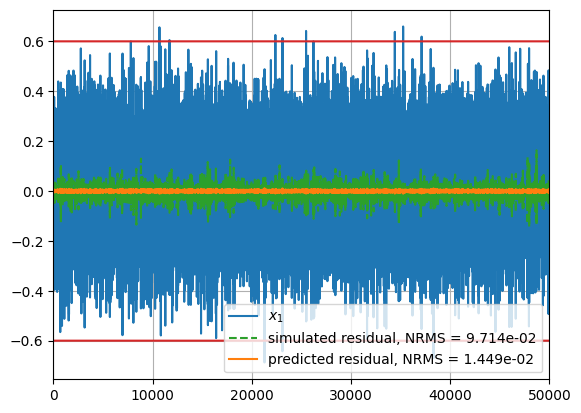

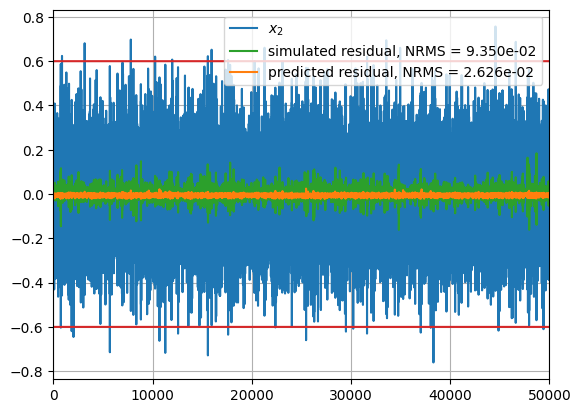

0.09531777551325334
0.02037572824109238


(None, None)

In [8]:
true = test.y
simulated = test_simulated
predicted = test_predicted

plt.plot(true[:,0], color='#1f77b4', label="$x_1$")
plt.plot(simulated[:,0]-true[:,0],"--", color='#2ca02c', label="simulated residual, NRMS = {:.3e}".format(NRMS(true[:,0],simulated[:,0])))
plt.plot(predicted[:-1,0]-true[1:,0], color='#ff7f0e', label="predicted residual, NRMS = {:.3e}".format(NRMS(true[1:,0], predicted[:-1,0])))
plt.plot(0.6*np.ones(true.shape[0]),"#d62728")
plt.plot(-0.6*np.ones(true.shape[0]),"#d62728")
plt.grid()
plt.legend()
plt.xlim([0, true.shape[0]])
plt.show()

plt.plot(true[:,1], color='#1f77b4', label="$x_2$")
plt.plot(simulated[:,1]-true[:,1], color='#2ca02c', label="simulated residual, NRMS = {:.3e}".format(NRMS(true[:,1],simulated[:,1])))
plt.plot(predicted[:-1,1]-true[1:,1], color='#ff7f0e', label="predicted residual, NRMS = {:.3e}".format(NRMS(true[1:,1], predicted[:-1,1])))
plt.plot(0.6*np.ones(true.shape[0]),"#d62728")
plt.plot(-0.6*np.ones(true.shape[0]),"#d62728")
plt.grid()
plt.legend()
plt.xlim([0, true.shape[0]])
plt.show()

print(np.mean(NRMS(true,simulated))),print(np.mean(NRMS(true[1:,:], predicted[:-1,:])))

In [9]:
# np.save("SINDy_test_res", simulated[:,0]-true[:,0])

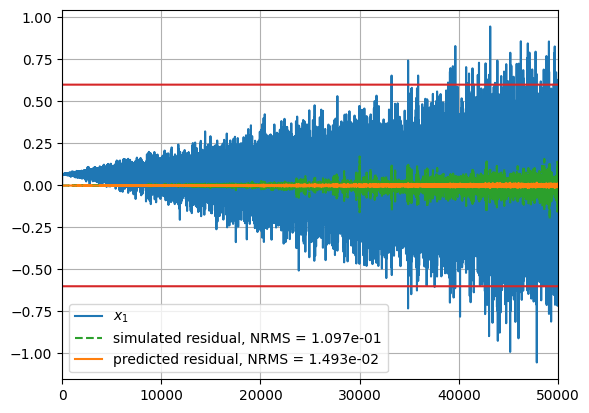

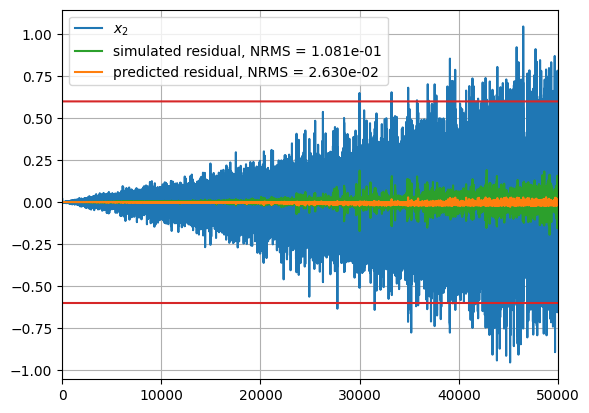

0.10893223061682789
0.020615179927495716


(None, None)

In [10]:
true = arrow.y
simulated = arrow_simulated
predicted = arrow_predicted

plt.plot(true[:,0], color='#1f77b4', label="$x_1$")
plt.plot(simulated[:,0]-true[:,0],"--", color='#2ca02c', label="simulated residual, NRMS = {:.3e}".format(NRMS(true[:,0],simulated[:,0])))
plt.plot(predicted[:-1,0]-true[1:,0], color='#ff7f0e', label="predicted residual, NRMS = {:.3e}".format(NRMS(true[1:,0], predicted[:-1,0])))
plt.plot(0.6*np.ones(true.shape[0]),"#d62728")
plt.plot(-0.6*np.ones(true.shape[0]),"#d62728")
plt.grid()
plt.legend()
plt.xlim([0, true.shape[0]])
plt.show()

plt.plot(true[:,1], color='#1f77b4', label="$x_2$")
plt.plot(simulated[:,1]-true[:,1], color='#2ca02c', label="simulated residual, NRMS = {:.3e}".format(NRMS(true[:,1],simulated[:,1])))
plt.plot(predicted[:-1,1]-true[1:,1], color='#ff7f0e', label="predicted residual, NRMS = {:.3e}".format(NRMS(true[1:,1], predicted[:-1,1])))
plt.plot(0.6*np.ones(true.shape[0]),"#d62728")
plt.plot(-0.6*np.ones(true.shape[0]),"#d62728")
plt.grid()
plt.legend()
plt.xlim([0, true.shape[0]])
plt.show()

print(np.mean(NRMS(true,simulated))),print(np.mean(NRMS(true[1:,:], predicted[:-1,:])))

In [11]:
# np.save("SINDy_arrow_res", simulated[:,0]-true[:,0])